In [2]:
from src.models.blip2 import SurroundBlipImageProcessor
model_name = "Salesforce/blip2-opt-2.7b" 

processor = SurroundBlipImageProcessor.from_pretrained(model_name)

c:\Users\Seungwoo\.conda\envs\sur\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
import pandas as pd
import numpy as np
# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 경로 설정
data_dir = Path("data/raw/QuIC360")

class QuIC360Dataset(Dataset):
    def __init__(self, csv_file, processor, max_length=30, split="train"):
        self.df = pd.read_csv(csv_file)
        self.processor = processor
        self.max_length = max_length
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        url = row['url']
        caption = row[1]  # 두 번째 열에 캡션이 있는 것으로 가정
        
        # 이미지 다운로드 및 로드
    
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        # print("image shape:", image.size)
        # 이미지와 텍스트 인코딩
        inputs = self.processor(
            images=image, 
            size = (224,224*2), # 224*2, 224*2
            text=caption, 
            do_crop=True,
            overlap_ratio=0.5,
            padding="max_length", 
            truncation=True, 
            max_length=self.max_length, 
            return_tensors="pt"
        )
        
        # 배치 차원 제거
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs
        
    
eval_dataset = QuIC360Dataset(data_dir/"valid.csv", processor, max_length=30, split="valid")

C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_12372\3015171528.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  caption = row[1]  # 두 번째 열에 캡션이 있는 것으로 가정
c:\Users\Seungwoo\.conda\envs\sur\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SurroundBlipImageProcessor.preprocess` and were ignored: 'text', 'padding', 'truncation', 'max_length'
  return self.preprocess(images, **kwargs)


img size: (6080, 3040)
image shape: (224, 448, 3)
img size: (5760, 2880)
image shape: (224, 448, 3)
img size: (4096, 2048)
image shape: (224, 448, 3)
img size: (4096, 2048)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


image shape: (224, 448, 3)
pixel_values 전체 shape: torch.Size([4, 4, 3, 224, 224])
첫 번째 배치의 patches shape: torch.Size([4, 3, 224, 224])


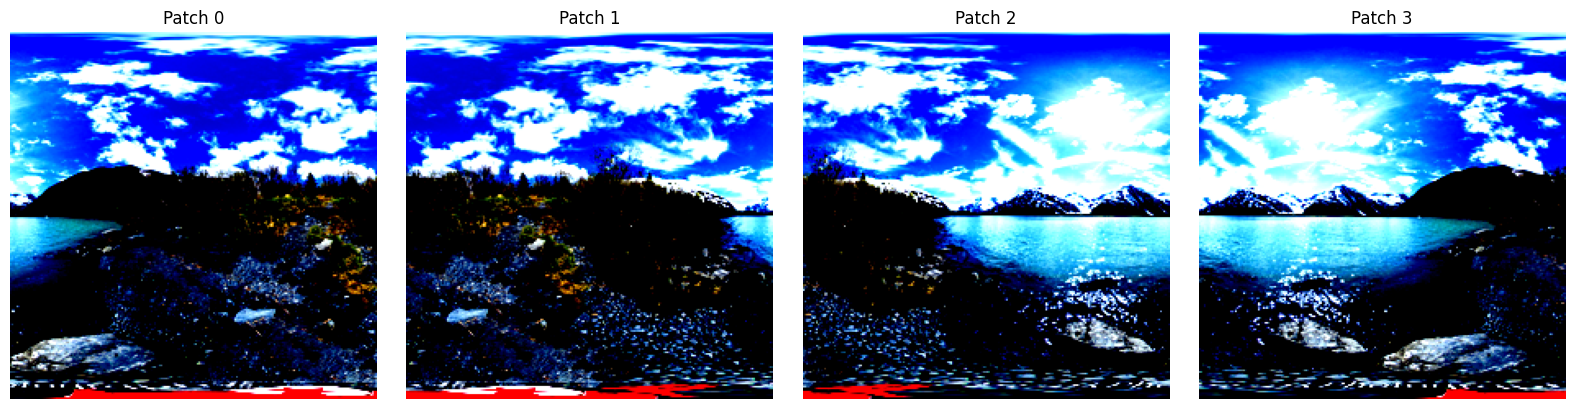

In [4]:
import matplotlib.pyplot as plt

loader = DataLoader(eval_dataset, batch_size=4, shuffle=False)

batch = next(iter(loader))
patches = batch["pixel_values"][0]  # 첫 번째 배치의 모든 패치, shape: [패치수, 3, 224, 224]
print("pixel_values 전체 shape:", batch["pixel_values"].shape)
print("첫 번째 배치의 patches shape:", patches.shape)
num_patches = patches.size(0)

plt.figure(figsize=(4 * num_patches, 4))

for i in range(num_patches):
    ax = plt.subplot(1, num_patches, i + 1)
    
    img = patches[i]
    
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"Patch {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()